In [4]:
# Imports
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Scipy center of mass function
from scipy.ndimage.measurements import center_of_mass as CoM

In [5]:
# Set the location of the LArCV 512x512 data
data_root = "/media/hdd1/kai/particle_generator/larcv_data/larcv_png_512/larcv_png_512/"

In [6]:
# List for appending image data
image_data = []

In [7]:
# Load the 512x512 data
print("Loading images from {}".format(data_root))

for image_path in os.listdir(data_root):
    in_path = os.path.join(data_root, image_path)
    image_data.append(cv.imread(in_path, 0))

print("Finished loading {} images".format(len(image_data)))

Loading images from /media/hdd1/kai/particle_generator/larcv_data/larcv_png_512/larcv_png_512/
Finished loading 74968 images


In [70]:
#########################################
imsize = 512 # Do not change this value #
#########################################

----
### Once the LArCV 512 image data is loaded, the cropping procedure can be run any number of times
----

In [89]:
# Set the desired crop size and set the save location for the new image crops
crop_dim = 32
crop_bound = crop_dim//2
save_path = "/media/hdd1/kai/particle_generator/larcv_data/larcv_png_{}/larcv_png_{}/".format(crop_dim, crop_dim)

In [90]:
# Set up list for saving cropped images
im_crops = []

In [91]:
# Set up variables for logging centroids
centroids_x = []; centroids_y = []

In [92]:
# Report the size of the image crops that will be generated
print("Original data image size: {}x{}".format(imsize,imsize))
print("Size of crops to be generated: {}x{}".format(crop_dim, crop_dim))
print("Cropping boundaries: ")
print("x_min: {} | x_max: {}".format(crop_bound, imsize - crop_bound))
print("y_min: {} | y_max: {}".format(crop_bound, imsize - crop_bound))

Original data image size: 512x512
Size of crops to be generated: 32x32
Cropping boundaries: 
x_min: 16 | x_max: 496
y_min: 16 | y_max: 496


### Compute set of cropped images

In [93]:
for idx, image in enumerate(image_data):

    # Get the weighted centroid position
    com = CoM(image)
    
    # check if computation returned NaN -- happens when centroid location is non-sensical
    if com[0] != com[0]:
        del image
        continue

    # Track centroids
    centroids_x.append(int(com[0]))
    centroids_y.append(int(com[1]))
    
    # Ensure that the centroid location in within acceptable bounds from the edge
    check_x = (centroids_x[-1] > crop_bound) and (centroids_x[-1] < (imsize - crop_bound))
    check_y = (centroids_y[-1] > crop_bound) and (centroids_y[-1] < (imsize - crop_bound))
    
    if check_x and check_y:
        # Set the bounds of the crop box based on centroid coordinates
        x1 = centroids_x[-1] - crop_bound; x2 = centroids_x[-1] + crop_bound
        y1 = centroids_y[-1] - crop_bound; y2 = centroids_y[-1] + crop_bound
        
        # Crop the image
        image = image[x1:x2, y1:y2]
        
        # Check that the cropped image is at least 1% filled
        pix_check = np.where(image > 0, 1, 0)
        pix_percentage = (np.sum(pix_check) / pix_check.flatten().shape[0]) >= 0.01
        if not pix_percentage:
            del image
            continue
        del pix_check
        
        # Image passes - append
        im_crops.append(image)
    else:
        del image
        continue

In [94]:
print("-"*60)
print("Generated {} images at [{}x{}] resolution".format(len(im_crops), crop_dim, crop_dim))
print("This represents ~{} percent of the original dataset".format( round(len(im_crops)/len(image_data),2) ) )
print("-"*60)

------------------------------------------------------------
Generated 55267 images at [32x32] resolution
This represents ~0.74 percent of the original dataset
------------------------------------------------------------


### Grab sample of newly cropped images

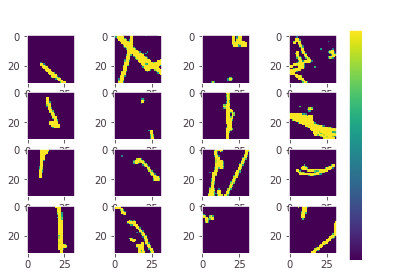

In [95]:
n_row = 4; n_col = 4
fig, axes = plt.subplots(n_row, n_col)
fig.suptitle("Selection of Cropped {}x{} LArCV1 Images".format(crop_dim, crop_dim), color="white")
img = None; im_num = 0
for i in range(0, n_row):
    for j in range(0, n_col):
        img = axes[i,j].imshow(im_crops[im_num])
        axes[i,j].spines['bottom'].set_color('white')
        axes[i,j].spines['top'].set_color('white')
        axes[i,j].spines['left'].set_color('white')
        axes[i,j].spines['right'].set_color('white')
        axes[i,j].xaxis.label.set_color('white')
        axes[i,j].yaxis.label.set_color('white')
        axes[i,j].tick_params(axis='x', colors='#443941')
        axes[i,j].tick_params(axis='y', colors='#443941')
        im_num += 1

# Colorbar
cbar_axes = fig.add_axes([0.9, 0.1, 0.03, 0.8])
cbar = plt.colorbar(img, cax=cbar_axes)
cbar.ax.yaxis.set_tick_params(color="white")
cbar.outline.set_edgecolor(color="white")
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color="white")

plt.savefig("random_selection_scipy_cropped_{}x{}_images.png".format(crop_dim, crop_dim), dpi=300, facecolor='#443941')

### Save newly cropped images to specified save_path

In [96]:
# Check that save_path exists
if not os.path.exists(save_path):
    os.makedirs(save_path)

for idx, crop in enumerate(im_crops):
    im_name = "larcv_{}_{}.png".format(crop_dim, idx)
    out_path = os.path.join(save_path, im_name)
    cv.imwrite(out_path, crop)

In [97]:
print("Saved {} images to: {}".format(len(im_crops), save_path))

Saved 55267 images to: /media/hdd1/kai/particle_generator/larcv_data/larcv_png_32/larcv_png_32/
